# Week 10 Practical - Question 1 Solution
## Face Recognition with an AutoEncoder

The 3rd Week 10 lecture example (Semi-Supervised Learning) uses a network which is an autoencoder, with a class-based output also included, and resulting from a couple of dense layers connected to the bottleneck. This network allows the autoencoder to class specific information, as the bottleneck layer must be useful for both reconstruction, and classification.

Extend this idea to face recognition. In doing so you should:
* Use the YaleB dataset to train the model. Look at the Week 7 practical solutions for code to prepare YaleB (and other face recognition datasets) for use in a DCNN.
* Modify the class-based output of the network to classify the face into the target identities.
* Use the trained network to extract bottleneck features, and train a simple classifier (i.e. a CKNN) for face recognition. Feel free to reuse code from earlier weeks (i.e. the week 7 practical solution) to achieve this.
* Evaluate the same network on the ORL and Yale face datasets. Consider how well the network trained on YaleB generalises to these other datasets, and compare this to the results observed in previous practicals that have dealt with this data (Week 6 and 7).

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import numpy
import scipy.io

from sklearn.manifold import TSNE

## Code Reuse

We're making heavy use of code from previous examples. In particular:
* ``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``, which used an autoencoder with a classification head connected to the bottleneck layer. The network setup is taken from here and adapted slightly.
* The Week 7 practical solution, which used the face rec datasets with a triplet network. The data loading, and face rec classifier training and evaluation is taken from here

Given the heavy code reuse, commentary with this solution will be somewhat sparse, and will focus on the new bits.

## Data Loading

Load YaleB, reshape into images, and display it. We'll also convert the labels to a categorical here as we want to use those with a classification head.

In [2]:
yale_b = scipy.io.loadmat('../../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

gnd = tf.keras.utils.to_categorical(gnd)
train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

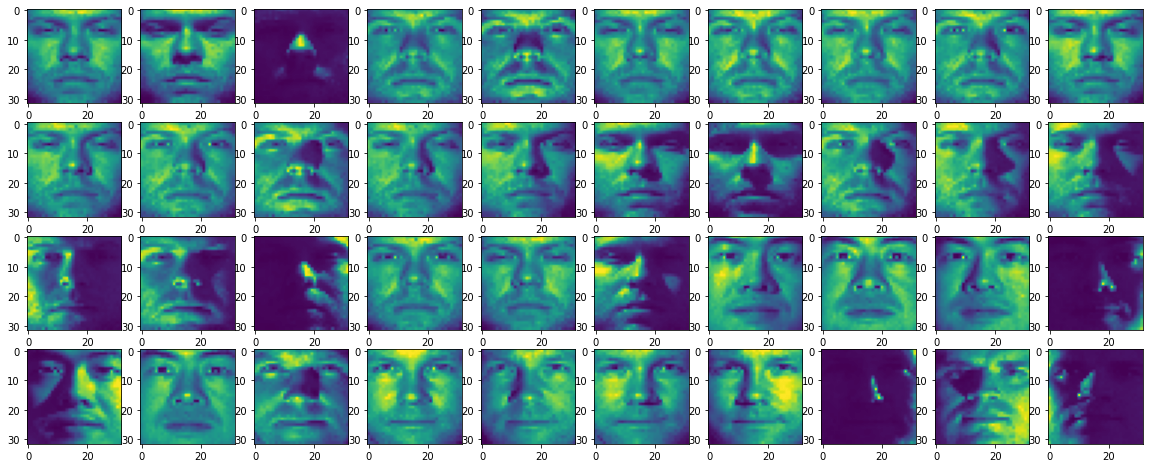

In [3]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

## Network Setup

Taken from the semi supervised learning example (``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``).

The class_output layer has been changed now to have the same number of classes as our dataset. Note that we have no other dense layers between the bottleneck and the class output. There are a few reasons for this:
* Keep it simple
* This is more likely to force the embedding to encode ID information, as there are fewer operations between the embedding and and the class output

In [4]:
def build_network():
    input_img = Input(shape=(32, 32, 1))

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

    # at this point the representation is (4, 4, 4) i.e. 64-dimensional
    encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

    # first output, we'll flatten the embedding, and pass it through a couple of dense layers to
    # get our output
    class_out = Flatten()(encoded)
    class_out = Dense(39, activation='softmax', name='class_output')(class_out)

    # second output, we'll do the usual decode to get our autoencoder output
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='autoenc_output')(x)

    multitask_cnn = Model(input_img, [class_out, decoded])

    return multitask_cnn

In [5]:
multitask_cnn = build_network()
multitask_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', 'mean_squared_error'])
print(multitask_cnn.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    1160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
history = multitask_cnn.fit(train_fea_reshape, [train_gnd, train_fea_reshape],
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_fea_reshape, [test_gnd, test_fea_reshape]), verbose=False)

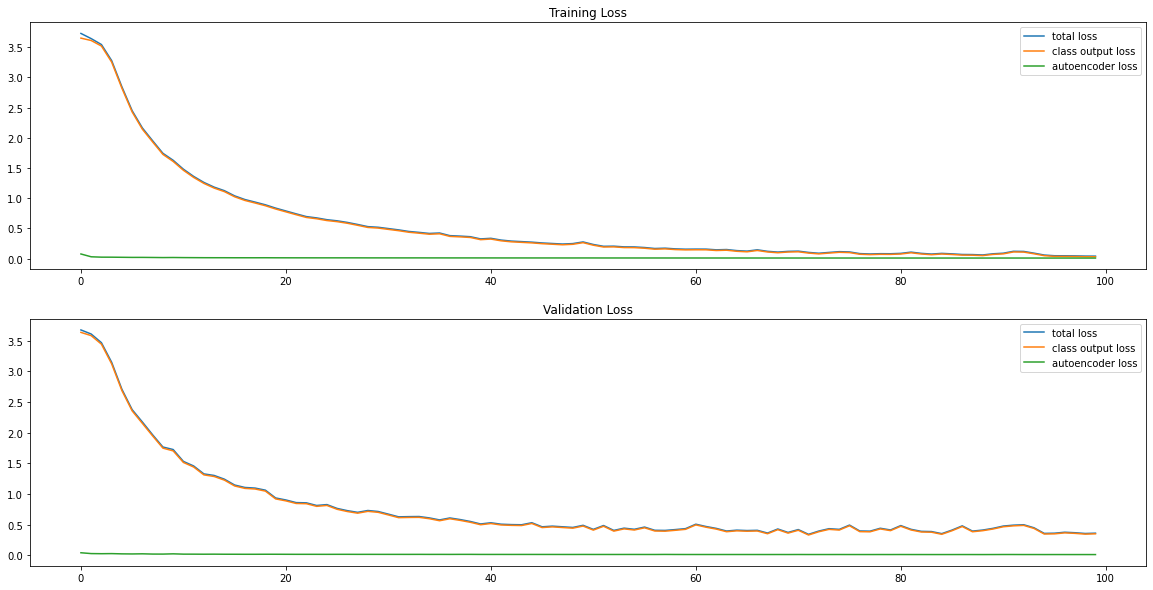

In [7]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(2, 1, 1)
ax.plot(history.history['loss'], label='total loss')
ax.plot(history.history['class_output_loss'], label='class output loss')
ax.plot(history.history['autoenc_output_loss'], label='autoencoder loss')
ax.set_title('Training Loss')
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(history.history['val_loss'], label='total loss')
ax.plot(history.history['val_class_output_loss'], label='class output loss')
ax.plot(history.history['val_autoenc_output_loss'], label='autoencoder loss')
ax.set_title('Validation Loss')
ax.legend()

Looking at the training results, the class loss dominates. This is ok, as our main aim is to learn how to do face rec. If this was a problem, or we wanted to put further focus on the face rec, we could alter loss weights as needed.

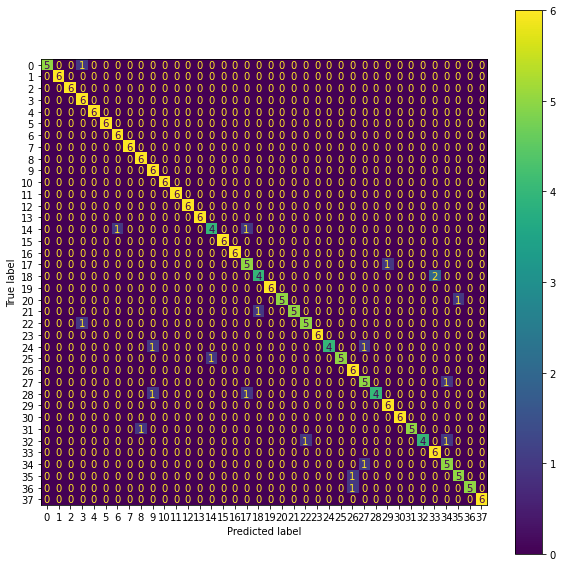

In [8]:
predictions, decoded_imgs = multitask_cnn.predict(test_fea_reshape);

indexes = tf.argmax(predictions, axis=1)
gt = tf.argmax(test_gnd, axis=1)

cm = confusion_matrix(gt, indexes)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax)

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Testing Embeddings')

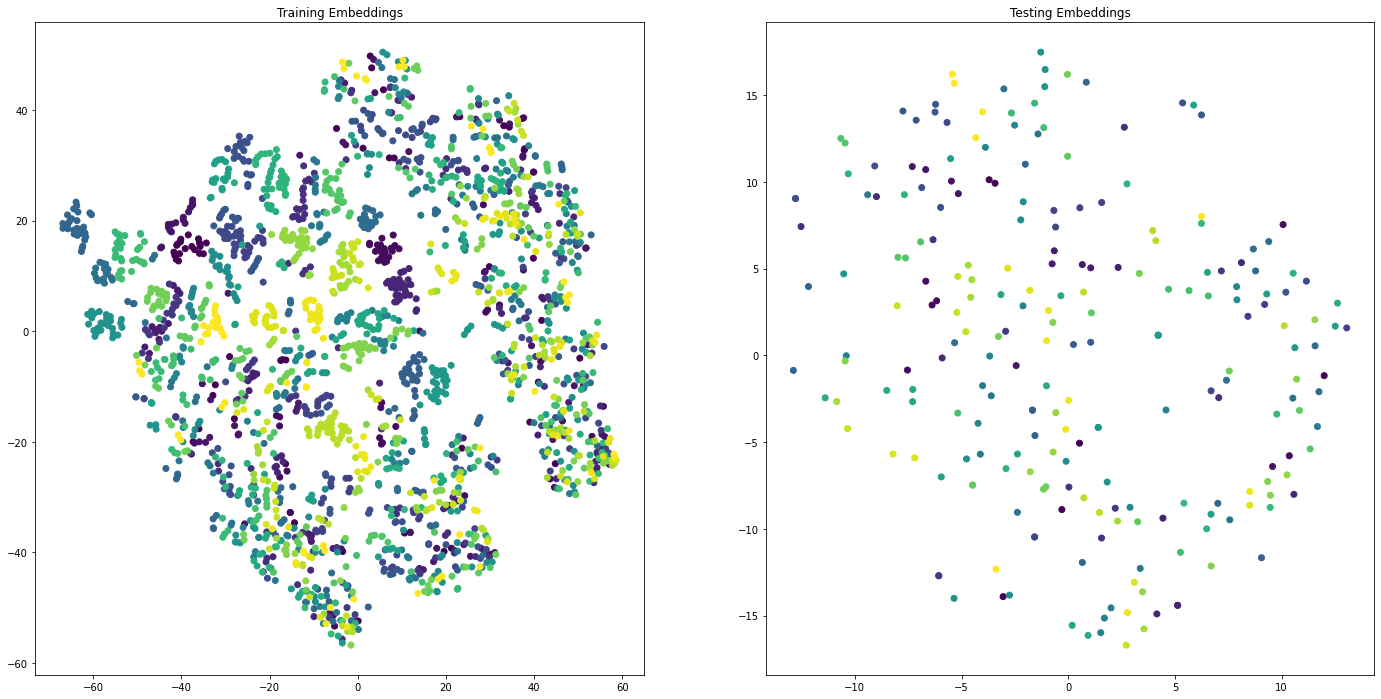

In [9]:
bottleneck_output = multitask_cnn.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = multitask_cnn.input, outputs = bottleneck_output)

train_embeddings = numpy.reshape(bottleneck_model.predict(train_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(train_embeddings)
fig = plt.figure(figsize=[24, 12])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(train_gnd, axis=1));
ax.set_title('Training Embeddings')

test_embeddings = numpy.reshape(bottleneck_model.predict(test_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(test_gnd, axis=1));
ax.set_title('Testing Embeddings')

Looking at embeddings and classification accuracy we see that:
* Compared to our embeddings from the triplet network (week 7 solution), we have no where near as tight a grouping
* Performance is quite a bit worse than we've seen before with the week 7 solution. Given the t-SNE plots, this is not a surprise.

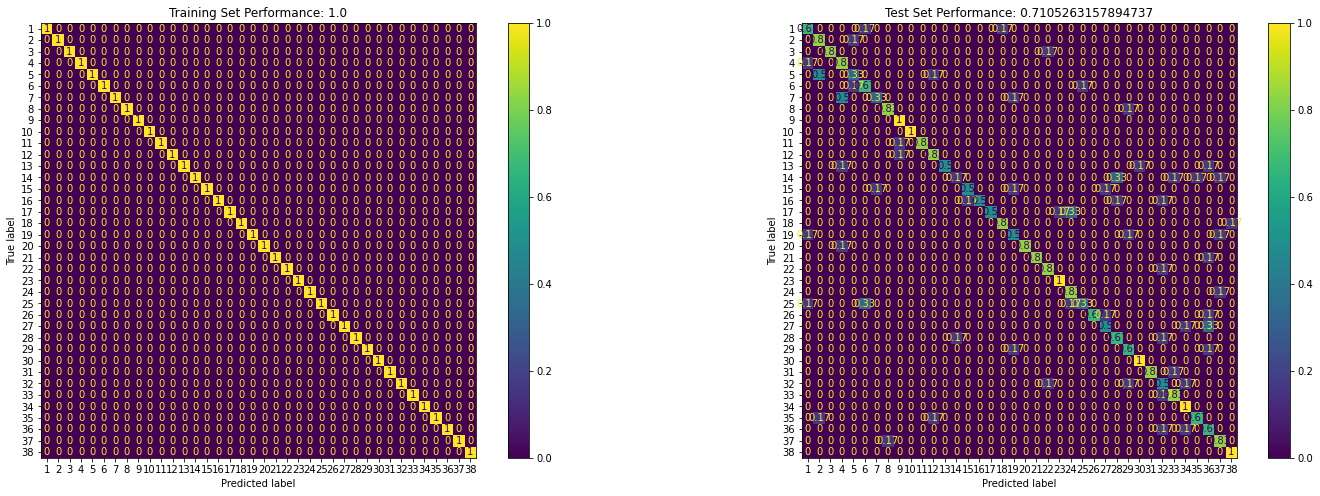

In [10]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])

    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    matches = (pred == Y_train).numpy()
    conf.ax_.set_title('Training Set Performance: %s' % (sum(matches)/len(matches)));

    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    matches = (pred == Y_test).numpy()
    conf.ax_.set_title('Test Set Performance: %s' % (sum(matches)/len(matches)));  
    
    
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(train_embeddings, tf.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, tf.argmax(train_gnd, axis=1), test_embeddings, tf.argmax(test_gnd, axis=1))   

## Will it Generalise? (or Blend?)

More code re-use here. This is all now pretty much verbatim from the Week 7 prac solution.

Let's look at performance on ORL.

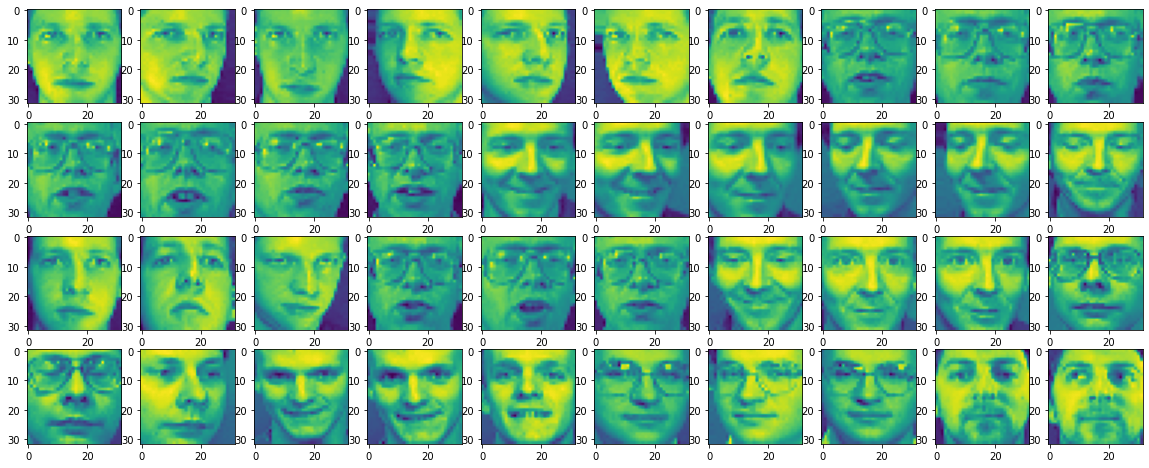

In [11]:
orl = scipy.io.loadmat('../../data/ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
gnd = tf.keras.utils.to_categorical(gnd)
train_fea = fea[train_frames, :]
train_gnd = gnd[train_frames, :]
test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_frames, 0)
test_gnd = numpy.delete(test_gnd, train_frames, 0)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])      

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


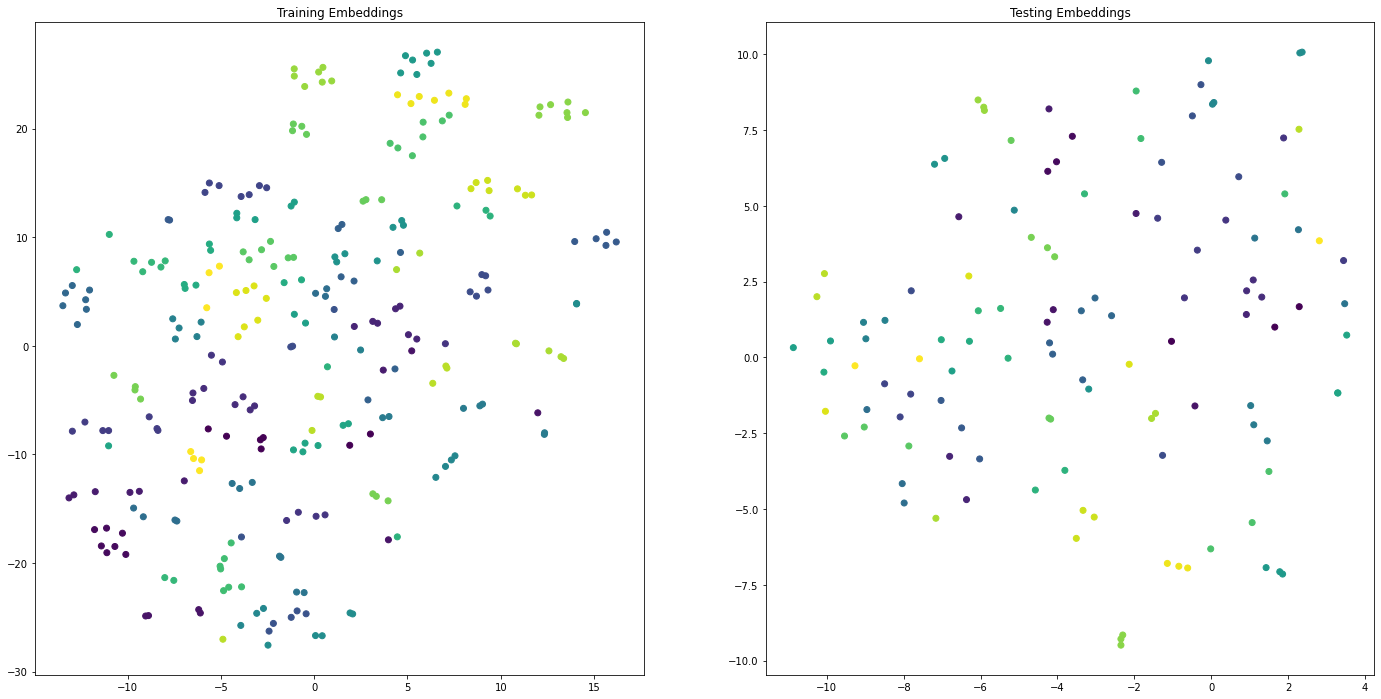

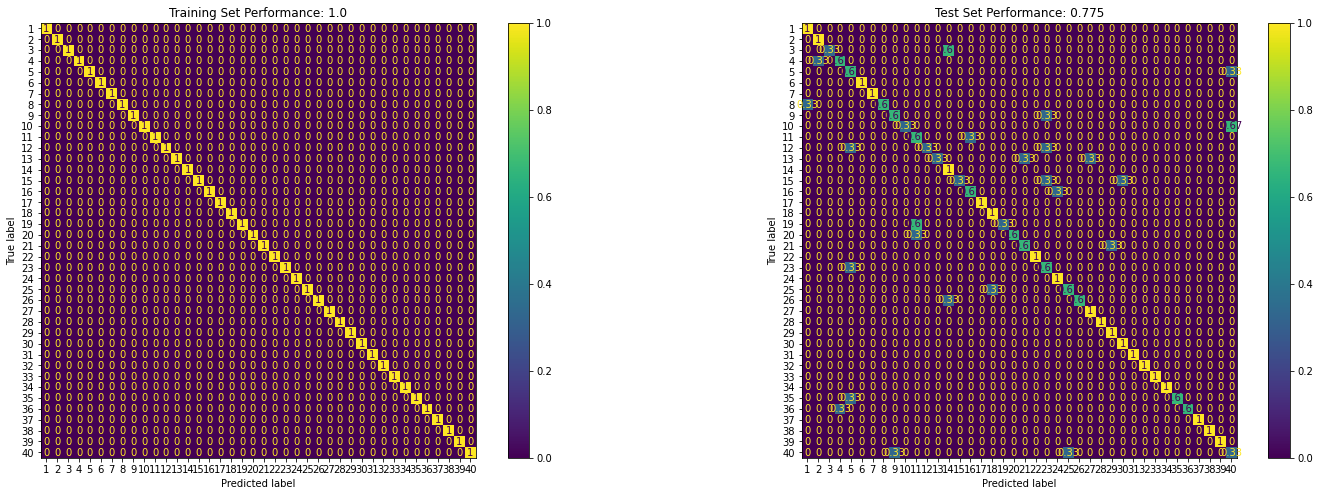

In [12]:
train_embeddings = numpy.reshape(bottleneck_model.predict(train_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(train_embeddings)
fig = plt.figure(figsize=[24, 12])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(train_gnd, axis=1));
ax.set_title('Training Embeddings')

test_embeddings = numpy.reshape(bottleneck_model.predict(test_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(test_gnd, axis=1));
ax.set_title('Testing Embeddings')    

cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(train_embeddings, tf.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, tf.argmax(train_gnd, axis=1), test_embeddings, tf.argmax(test_gnd, axis=1))   

This actually works ok, and is better than what we saw with the Siamese network, or LDA.

On to the Yale data now.

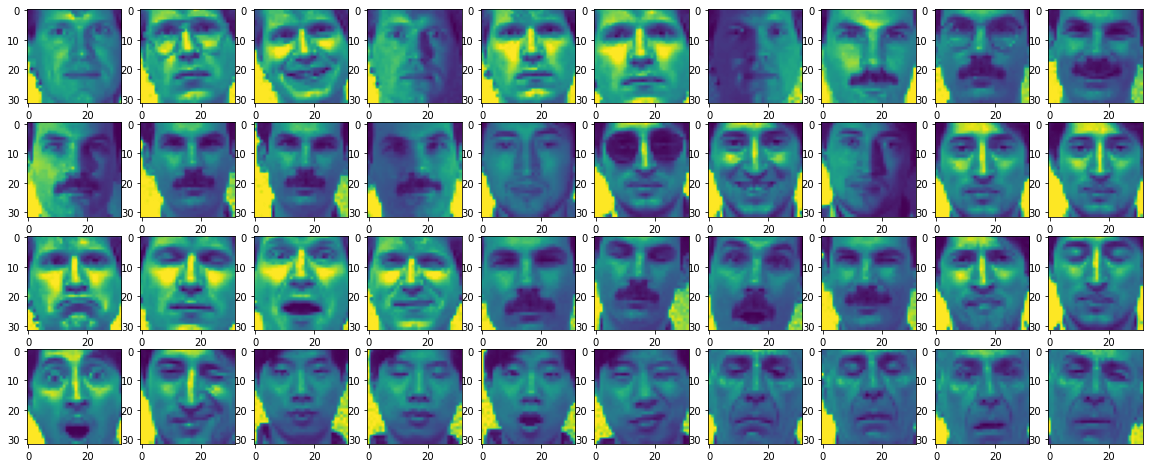

In [13]:
yale = scipy.io.loadmat('../../data/Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

gnd = tf.keras.utils.to_categorical(gnd)
train_fea = fea[train_frames, :]
train_gnd = gnd[train_frames, :]
test_fea = fea
test_gnd = gnd
test_fea = numpy.delete(test_fea, train_frames, 0)
test_gnd = numpy.delete(test_gnd, train_frames, 0)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])     

/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simondenman/venv/CAB420/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


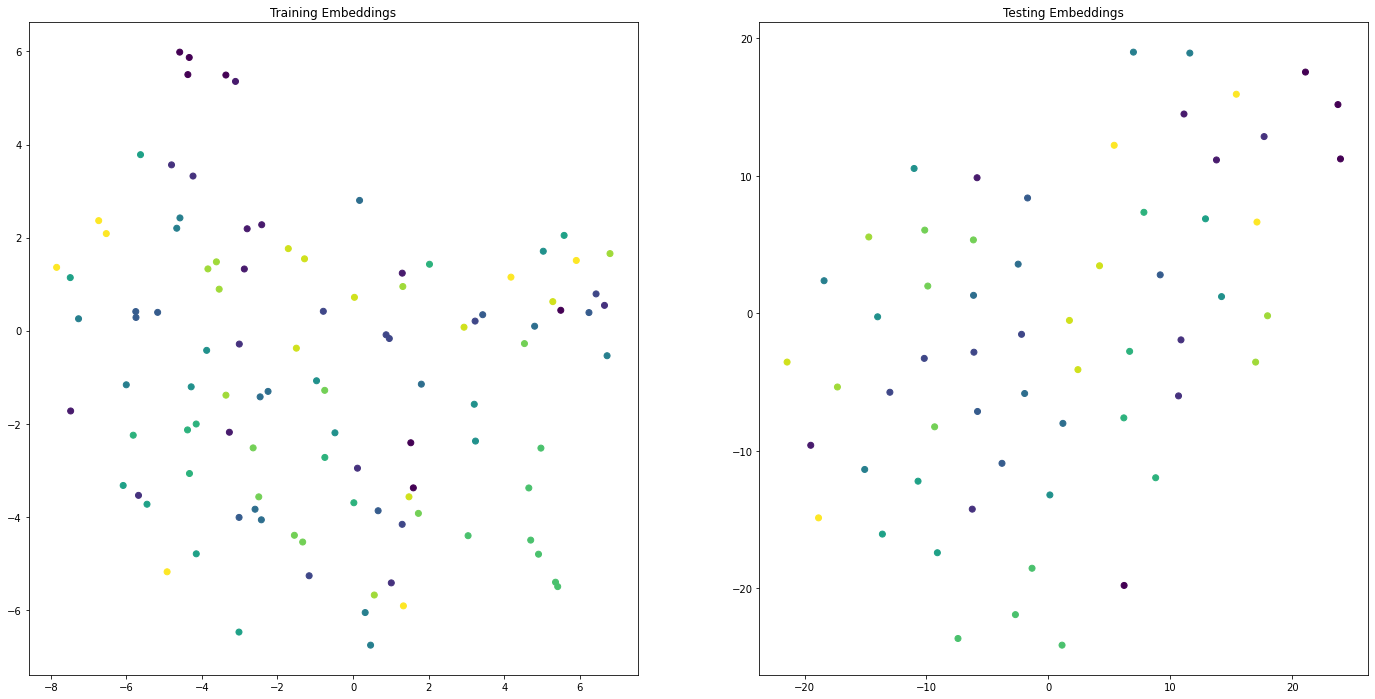

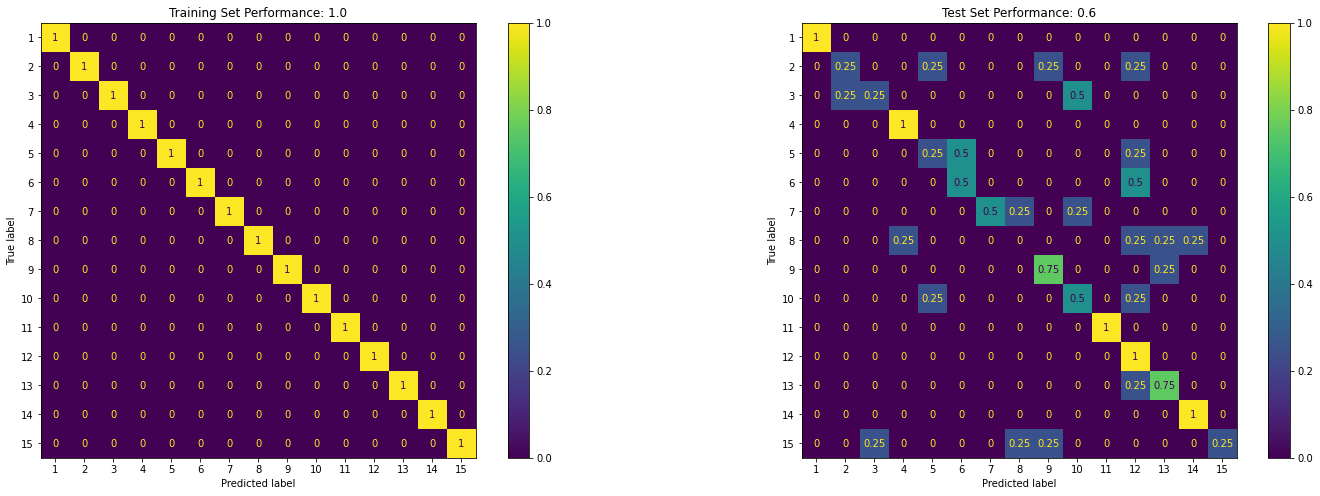

In [14]:
train_embeddings = numpy.reshape(bottleneck_model.predict(train_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(train_embeddings)
fig = plt.figure(figsize=[24, 12])
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(train_gnd, axis=1));
ax.set_title('Training Embeddings')

test_embeddings = numpy.reshape(bottleneck_model.predict(test_fea_reshape), (-1, 64))
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = tf.argmax(test_gnd, axis=1));
ax.set_title('Testing Embeddings')    

cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn.fit(train_embeddings, tf.argmax(train_gnd, axis=1))
eval_model(cknn, train_embeddings, tf.argmax(train_gnd, axis=1), test_embeddings, tf.argmax(test_gnd, axis=1))  

We see, as per previous examples, we struggle more on the Yale dataset than others. But we're still doing better than we did with a triplet network.

## Why does this work better than a triplet network?

It's important to remember that for YaleB, on which it is trained, it doesn't. It is however better on ORL and Yale. The reason is that we've focused on a more general task - our autoencoder. We've forced that to also learn a certain amount of class data via the classification head, but the combined task is still more general, which leads to the improved performance on out-domain data.